# Importing libraries

In [ ]:
import cv2
import os
import csv
from google.colab import drive
import pandas as pd
import random
import torch
import re
import numpy as np
from PIL import Image
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import time
from typing import Dict
from math import nan
from math import isnan
import imageio.v2 as imageio


drive.mount('/content/drive', force_remount=True)

def seed_torch(seed=1111):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print ("Cuda device not found.")
    device = torch.device("mps")

print(device)

if torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)


Mounted at /content/drive
Cuda device not found.
mps
cpu


# Utility functions

In [ ]:
def parse_coordinate(value):
    value = value.strip('()')  # Remove the parentheses
    x_str, y_str = value.split(', ')
    return float(x_str), float(y_str)

In [ ]:
#@title Normalization function
def normalize_coordinate(value, min_x, max_x, min_y, max_y):
    try:
        x, y = parse_coordinate(value)
        normalized_x = (x - min_x) / (max_x - min_x)
        normalized_y = (y - min_y) / (max_y - min_y)
        return normalized_x, normalized_y
    except ValueError as e:
        print(f"Skipping value: {value} due to error: {e}")
        return None, None

def minmax_normalization_data(df, min_x, max_x, min_y, max_y):
    for col in df.columns:
        if col.startswith('X'):
            # Extract X and Y values from each column and normalize them
            normalized_values = []
            for value in df[col]:
              if pd.isna(value):
                  normalized_values.append((0, 0))
              else:
                  normalized_x, normalized_y = normalize_coordinate(value, min_x, max_x, min_y, max_y)
                  normalized_values.append((normalized_x, normalized_y))
            df[col] = normalized_values
    return df


In [ ]:
def unnormalize_coordinate(normalized_value, min_x, max_x, min_y, max_y):
    normalized_x, normalized_y = normalized_value
    x = normalized_x * (max_x - min_x) + min_x
    y = normalized_y * (max_y - min_y) + min_y
    return x, y

def minmax_unnormalization_data(df, min_x, max_x, min_y, max_y):
    for col in df.columns:
        if col.startswith('X'):
            # Extract normalized X and Y values from each column and unnormalize them
            unnormalized_values = []
            for normalized_value in df[col]:
                if normalized_value == (0, 0):  # Handle NaN or missing values
                    unnormalized_values.append(None)  # or any other appropriate handling
                else:
                    x, y = unnormalize_coordinate(normalized_value, min_x, max_x, min_y, max_y)
                    unnormalized_values.append((x, y))
            df[col] = unnormalized_values
    return df

In [ ]:
#@title Plotting function
def plot_trajectories(input_trajectory, target_trajectory, prediction_data, index):
    """
    Plot input + prediction and input + target trajectories.

    Args:
    - input_trajectory: Array of input trajectories, shape (num_samples, seq_length, 2)
    - target_trajectory: Array of target trajectories, shape (num_samples, seq_length, 2)
    - prediction_data: Dictionary of predicted trajectories, keys are IDs, values are trajectories
    - index: ID of the sample to plot
    """

    prediction_trajectory = prediction_data[index]
    input_trajectory, target_trajectory, prediction_trajectory = input_trajectory.to('cpu'), target_trajectory.to('cpu'), prediction_trajectory.to('cpu')

    input_trajectory = input_trajectory[(input_trajectory[:, 0] != 0) | (input_trajectory[:, 1] != 0)]
    target_trajectory = target_trajectory[(target_trajectory[:, 0] != 0) | (target_trajectory[:, 1] != 0)]
    prediction_trajectory = prediction_trajectory[(prediction_trajectory[:, 0] != 0) | (prediction_trajectory[:, 1] != 0)]

    plt.figure(figsize=(8, 6))

    # Plot input trajectory
    plt.plot(input_trajectory[:, 0], input_trajectory[:, 1], 'bo-', label='Input')
    # Plot prediction trajectory
    plt.plot(prediction_trajectory[:, 0], prediction_trajectory[:, 1], 'ro-', label='Prediction')
    # Plot target trajectory
    plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], 'go-', label='Target')

    plt.title(f'Trajectory car {index}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()

    # Set number formatting for x and y axes
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))

    plt.gca().grid(False)
    plt.show()

In [ ]:
#@title GIF function
def create_gif_trajectories(input_trajectory, target_trajectory, prediction_data, index):
    """
    Create a GIF showing the input, target, and prediction trajectories appearing one by one.

    Args:
    - input_trajectory: Array of input trajectories, shape (num_samples, seq_length, 2)
    - target_trajectory: Array of target trajectories, shape (num_samples, seq_length, 2)
    - prediction_data: Dictionary of predicted trajectories, keys are IDs, values are trajectories
    - index: ID of the sample to plot
    """

    filename = f'/content/drive/MyDrive/Computer Vision/CV Project/GIF/GIF{index}/trajectory{index}.gif'
    path =  f'/content/drive/MyDrive/Computer Vision/CV Project/GIF/GIF{index}'

    try:
        os.makedirs(path, exist_ok=True)
    except Exception as e:
        print(f"Error creating directory '{path}': {e}")

    prediction_trajectory = prediction_data[index]
    input_trajectory, target_trajectory, prediction_trajectory = input_trajectory.to('cpu'), target_trajectory.to('cpu'), prediction_trajectory.to('cpu')

    input_trajectory = input_trajectory[(input_trajectory[:, 0] != 0) | (input_trajectory[:, 1] != 0)]
    target_trajectory = target_trajectory[(target_trajectory[:, 0] != 0) | (target_trajectory[:, 1] != 0)]
    prediction_trajectory = prediction_trajectory[(prediction_trajectory[:, 0] != 0) | (prediction_trajectory[:, 1] != 0)]

    # Find the global limits for the axes
    x_min = min(input_trajectory[:, 0].min(), target_trajectory[:, 0].min(), prediction_trajectory[:, 0].min())
    x_max = max(input_trajectory[:, 0].max(), target_trajectory[:, 0].max(), prediction_trajectory[:, 0].max())
    y_min = min(input_trajectory[:, 1].min(), target_trajectory[:, 1].min(), prediction_trajectory[:, 1].min())
    y_max = max(input_trajectory[:, 1].max(), target_trajectory[:, 1].max(), prediction_trajectory[:, 1].max())

    # Initialize lists to hold the frames
    new_frames = []

    for i in range(len(input_trajectory)):
        plt.figure(figsize=(8, 6))

        plt.plot(input_trajectory[:i+1, 0], input_trajectory[:i+1, 1], 'bo-', label='Input')

        plt.title(f'Trajectory car {index}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()

        # Set number formatting for x and y axes
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))

        # Set plot background color to white and remove grid
        plt.gca().set_facecolor('white')
        plt.gca().grid(False)  # Disable the grid

        # Set fixed axis limits
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        # Save the current frame
        new_frame_filename = f'/content/drive/MyDrive/Computer Vision/CV Project/GIF/GIF{index}/_frame_{i}.png'
        plt.savefig(new_frame_filename)
        new_frames.append(new_frame_filename)
        plt.close()

    for i in range(len(prediction_trajectory)):
        plt.figure(figsize=(8, 6))

        plt.plot(input_trajectory[:, 0], input_trajectory[:, 1], 'bo-', label='Input')

        # Plot prediction trajectory points
        plt.plot(prediction_trajectory[:i+1, 0], prediction_trajectory[:i+1, 1], 'ro-', label='Prediction')

        # Plot target trajectory points
        plt.plot(target_trajectory[:i+1, 0], target_trajectory[:i+1, 1], 'go-', label='Target')

        plt.title(f'Trajectory car {index}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()

        # Set number formatting for x and y axes
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))

        # Set plot background color to white and remove grid
        plt.gca().set_facecolor('white')
        plt.gca().grid(False)  # Disable the grid

        # Set fixed axis limits
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        # Save the current frame
        new_frame_filename = f'/content/drive/MyDrive/Computer Vision/CV Project/GIF/GIF{index}/_frame_{i+len(input_trajectory)}.png'
        plt.savefig(new_frame_filename)
        new_frames.append(new_frame_filename)
        plt.close()

    # Create the GIF
    new_images = [imageio.imread(frame) for frame in new_frames]
    imageio.mimsave(filename, new_images, duration=0.5, loop=0)

    # Remove the temporary frame files
    for frame_filename in new_frames:
        os.remove(frame_filename)

# Data preparation


## Video conversion into frames

3Hz, so 1/10 of the original frame rate, was used to extract frames from the video. A csv file is created containing the frame file name

```
[videoname]_frame[cnt].jpeg
```
and the relative timestamp of the video.

In [ ]:
def video_to_frames(video_path, folder_path, csv_file, testing = False):
    # Make sure the folder exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Load the video
    if (testing == True):
      video_path = '/content/drive/My Drive/Computer Vision/CV Project/testing_videos/' + video_path
    else:
      video_path = '/content/drive/My Drive/Computer Vision/CV Project/annotated_videos/' + video_path

    cap = cv2.VideoCapture(video_path)

    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
      print(f"Failed to get FPS")

    # Calculate the frame skip value
    frame_skip = 10

    # Get the video name (without extension)
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    # Initialize frame counter
    cnt = 0

    while(cap.isOpened()):
        # Read the video frame
        ret, frame = cap.read()

        if ret == True:
            # Save each frame to the specified folder
            if cnt % frame_skip == 0:
                frame_file_name = f'{video_name}_frame{cnt}.jpg'
                frame_path = os.path.join(folder_path,frame_file_name)
                cv2.imwrite(frame_path,frame)
                csv_file.writerow([frame_file_name, cnt / fps])
            cnt += 1
        else:
            break

    cap.release()

Train

In [ ]:
# Open the CSV file for writing
with open('/content/drive/My Drive/Computer Vision/CV Project/frames_timestamps.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Frame", "Timestamp"])

    # Call the function for each video
    video_folder = '/content/drive/My Drive/Computer Vision/CV Project/annotated_videos'
    video_paths = [f for f in os.listdir(video_folder) if f.endswith('.avi')]
    print(video_paths)
    for video_path in video_paths:
        print(f"Processing {video_path}")
        video_to_frames(video_path, '/content/drive/My Drive/Computer Vision/CV Project/frames', writer)

['769.avi', '770.avi', '771.avi', '775.avi', '776.avi', '777.avi', '778.avi', '779.avi', '780.avi', '782.avi', '783.avi', '784.avi', '785.avi']
Processing 769.avi
Processing 770.avi
Processing 771.avi
Processing 775.avi
Processing 776.avi
Processing 777.avi
Processing 778.avi
Processing 779.avi
Processing 780.avi
Processing 782.avi
Processing 783.avi
Processing 784.avi
Processing 785.avi


Test

In [ ]:
# Open the CSV file for writing
with open('/content/drive/My Drive/Computer Vision/CV Project/test_frames_timestamps.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Frame", "Timestamp"])

    # Call the function for each video
    video_folder = '/content/drive/My Drive/Computer Vision/CV Project/testing_videos'
    video_paths = [f for f in os.listdir(video_folder) if f.endswith('.avi')]
    print(video_paths)
    for video_path in video_paths:
        video_to_frames(video_path, '/content/drive/My Drive/Computer Vision/CV Project/testing_videos/testing_frames', writer, True)

['781.avi']


###Some examples of the frames.

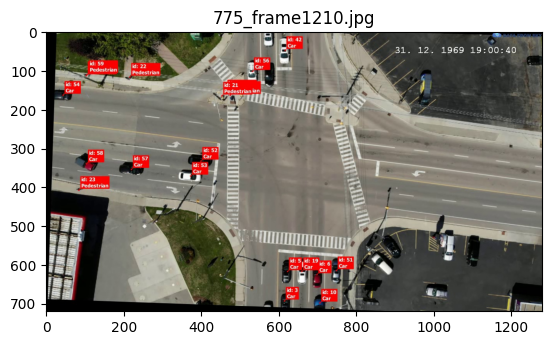

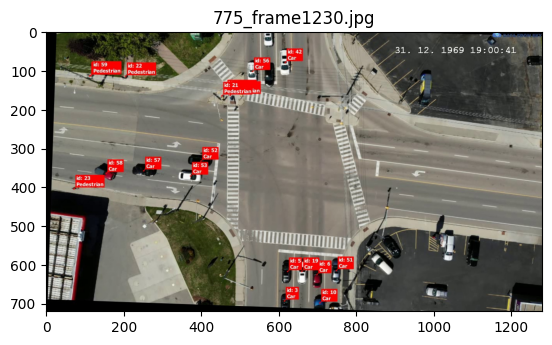

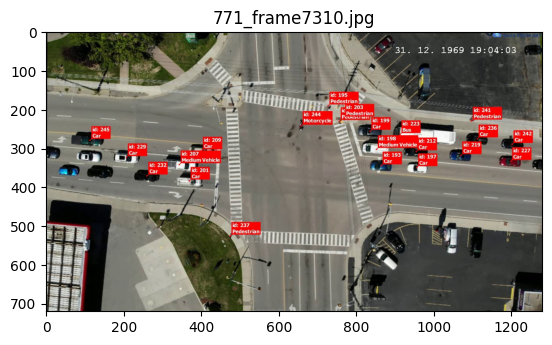

In [ ]:
# Specify the folder where the images are saved
folder_path = '/content/drive/My Drive/Computer Vision/CV Project/frames'

# Specify the names of the images you want to display
image_names = ['775_frame1210.jpg', '775_frame1230.jpg', '771_frame7310.jpg']

for image_name in image_names:
    # Load the image
    image = cv2.imread(os.path.join(folder_path, image_name))

    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image)
    plt.title(image_name)
    plt.show()


## A column "ref_number" is added to all the TRAJECTORIES_0{ref_number} and merging all the tables.

In [ ]:
main_folder_path = "/content/drive/MyDrive/Computer Vision/CV Project/CSV_files"

subfolders = [f.name for f in os.scandir(main_folder_path) if f.is_dir()]

all_data = pd.DataFrame()

for subfolder in subfolders:

    number = subfolder.split('_')[-1]

    if number in ['769', '770', '771', '775', '776', '777', '778', '779', '780', '782', '783', '784', '785']:

      file_path = os.path.join(main_folder_path, subfolder, f"TRAJECTORIES_0{number}.csv")

      df = pd.read_csv(file_path)

      df['ref_number'] = number

      all_data = pd.concat([all_data, df])

all_data.to_csv("/content/drive/MyDrive/Computer Vision/CV Project/all_data.csv", index=False)


#Testing
test_data = pd.DataFrame()
number = 781
test_file_path = f'/content/drive/MyDrive/Computer Vision/CV Project/CSV_files/ints_data_{number}/TRAJECTORIES_0{number}.csv'
df = pd.read_csv(file_path)
df['ref_number'] = number
test_data = pd.concat([test_data, df])
test_data.to_csv("/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_data.csv", index=False)


Check if the total entries is correct

In [ ]:
csv_file_path = "/content/drive/MyDrive/Computer Vision/CV Project/all_data.csv"

df = pd.read_csv(csv_file_path)
print(df.head())
total_entries = len(df)
print(f"Numero totale di entry: {total_entries}")

   TRACK_ID          X           Y   SPEED  TAN_ACC  LAT_ACC      TIME  \
0         1  538866.55  4814041.09  3.7803   0.0013   0.0083  0.000000   
1         1  538866.58  4814041.11  3.7806   0.0037   0.0095  0.033367   
2         1  538866.61  4814041.13  3.7812   0.0060   0.0107  0.066733   
3         1  538866.64  4814041.15  3.7822   0.0097   0.0117  0.100100   
4         1  538866.67  4814041.17  3.7837   0.0149   0.0127  0.133467   

    ANGLE TRAFFIC_REGIONS  ref_number  
0  0.5165             NaN         775  
1  0.5143             NaN         775  
2  0.5120             NaN         775  
3  0.5097             NaN         775  
4  0.5073             NaN         775  
Numero totale di entry: 2454777


## Join the two csv files "*all_data.csv*" and "*frames_timestamps.csv*" on the time and the reference number

In [ ]:
all_csv = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/all_data.csv')
frames_timestamps = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/frames_timestamps.csv')

all_csv['TIME'] = all_csv['TIME'].round(6)
frames_timestamps['Timestamp'] = frames_timestamps['Timestamp'].round(6)

frames_timestamps['ref_number'] = frames_timestamps['Frame'].str.extract('(\d{3})').astype(int)

merged = pd.merge(all_csv, frames_timestamps, left_on=['TIME', 'ref_number'], right_on=['Timestamp', 'ref_number'])

merged.to_csv('/content/drive/MyDrive/Computer Vision/CV Project/final_data.csv', index=False)

Test

In [ ]:
test_csv = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_data.csv')
test_frames_timestamps = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/test_frames_timestamps.csv')

test_csv['TIME'] = test_csv['TIME'].round(6)
test_frames_timestamps['Timestamp'] = test_frames_timestamps['Timestamp'].round(6)

test_frames_timestamps['ref_number'] = test_frames_timestamps['Frame'].str.extract('(\d{3})').astype(int)

merged = pd.merge(test_csv, test_frames_timestamps, left_on=['TIME', 'ref_number'], right_on=['Timestamp', 'ref_number'])

merged.to_csv('/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_data.csv', index=False)

##Temporalization inclusion


X,Y

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/final_data.csv')

# Group by ref_number and TRACK_ID, then sort by Timestamp
grouped = df.groupby(['ref_number', 'TRACK_ID']).apply(lambda x: x.sort_values(by='Timestamp')).reset_index(drop=True)

# Define a function to generate the new columns
def generate_coordinates(group):
    first = group.iloc[0]
    latest = group.iloc[-1]
    # Get the TRACK_ID and ref_number
    track_id = group['TRACK_ID'].iloc[0]
    ref_number = group['ref_number'].iloc[0]

    # Calculate the split point
    split_point = int(len(group) * 3 / 4)

    # Initialize a dictionary to store the new row
    new_row = {
        'TRACK_ID': track_id,
        'First_Last_Timestamps': (first['Timestamp'], latest['Timestamp']),
    }

    # Initialize a list to store frames relative to Xs, Ys before and including X,Y
    frames_list = []

    # Add the coordinate pairs for the first 3/4 with descending order suffixes
    for i, row in enumerate(group.iloc[:split_point-1].itertuples()):
        new_row[f'X-{(split_point-i-1)*10},Y-{(split_point-i-1)*10}'] = (row.X, row.Y)
        frames_list.append(row.Frame)

    # Add the coordinate pair at the split point (3/4 point)
    new_row['X,Y'] = (group['X'].iloc[split_point-1], group['Y'].iloc[split_point-1])
    frames_list.append(group['Frame'].iloc[split_point-1])

    # Add the frames list to the new row
    new_row['Frames'] = frames_list[-1]

    # Add the coordinate pairs for the last 1/4 with ascending order suffixes
    for i, row in enumerate(group.iloc[split_point:].itertuples(), start=1):
        new_row[f'X+{i*10},Y+{i*10}'] = (row.X, row.Y)

    return new_row

# Apply the function to each group and concatenate the results
result = grouped.groupby(['ref_number', 'TRACK_ID']).apply(generate_coordinates).apply(pd.Series)

# Reset index to get a clean DataFrame
result.reset_index(drop=True, inplace=True)

# Check if 'First_Last_Timestamps' and 'Frames' columns exist in the result DataFrame
if 'First_Last_Timestamps' in result.columns and 'Frames' in result.columns:
    # Reorder the columns to ensure correct order
    cols = ['TRACK_ID', 'First_Last_Timestamps', 'Frames'] + \
           sorted([col for col in result.columns if col.startswith('X-')], key=lambda x: int(x.split('-')[1].split(',')[0]), reverse=True) + \
           ['X,Y'] + \
           sorted([col for col in result.columns if col.startswith('X+')], key=lambda x: int(x.split('+')[1].split(',')[0]))

    result = result[cols]
else:
    print("Columns 'First_Last_Timestamps' and 'Frames' are not found in the resulting DataFrame.")

# Save the result to a new CSV file
result.to_csv('/content/drive/MyDrive/Computer Vision/CV Project/trajectory_data.csv', index=False)

Test

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_data.csv')

# Group by ref_number and TRACK_ID, then sort by Timestamp
grouped = df.groupby(['ref_number', 'TRACK_ID']).apply(lambda x: x.sort_values(by='Timestamp')).reset_index(drop=True)

# Apply the function to each group and concatenate the results
result = grouped.groupby(['ref_number', 'TRACK_ID']).apply(generate_coordinates).apply(pd.Series)

# Reset index to get a clean DataFrame
result.reset_index(drop=True, inplace=True)

# Check if 'First_Last_Timestamps' and 'Frames' columns exist in the result DataFrame
if 'First_Last_Timestamps' in result.columns and 'Frames' in result.columns:
    # Reorder the columns to ensure correct order
    cols = ['TRACK_ID', 'First_Last_Timestamps', 'Frames'] + \
           sorted([col for col in result.columns if col.startswith('X-')], key=lambda x: int(x.split('-')[1].split(',')[0]), reverse=True) + \
           ['X,Y'] + \
           sorted([col for col in result.columns if col.startswith('X+')], key=lambda x: int(x.split('+')[1].split(',')[0]))

    result = result[cols]
else:
    print("Columns 'First_Last_Timestamps' and 'Frames' are not found in the resulting DataFrame.")

# Save the result to a new CSV file
result.to_csv('/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_trajectory_data.csv', index=False)

Status

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/final_data.csv')

# Group by ref_number and TRACK_ID, then sort by Timestamp
grouped = df.groupby(['ref_number', 'TRACK_ID']).apply(lambda x: x.sort_values(by='Timestamp')).reset_index(drop=True)

# Define a function to generate the new columns
def generate_status(group):
    first = group.iloc[0]
    latest = group.iloc[-1]
    # Get the TRACK_ID and ref_number
    track_id = group['TRACK_ID'].iloc[0]
    ref_number = group['ref_number'].iloc[0]

    # Calculate the split point
    split_point = int(len(group) * 3 / 4)

    # Initialize a dictionary to store the new row
    new_row = {
        'TRACK_ID': track_id,
        'First_Last_Timestamps': (first['Timestamp'], latest['Timestamp']),
    }

    # Initialize a list to store frames relative to STATUS, and SPEED, TAN_ACC, LAT_ACC, ANGLE before and after STATUS
    frames_list = []

    # Add the data for the first 3/4 with descending order suffixes
    for i, row in enumerate(group.iloc[:split_point-1].itertuples()):
        new_row[f'STATUS-{(split_point-i-1)*10}'] = (row.SPEED, row.TAN_ACC, row.LAT_ACC, row.ANGLE)
        frames_list.append(row.Frame)

    # Add the data at the split point (3/4 point)
    new_row['STATUS'] = (group['SPEED'].iloc[split_point-1], group['TAN_ACC'].iloc[split_point-1], group['LAT_ACC'].iloc[split_point-1], group['ANGLE'].iloc[split_point-1])
    frames_list.append(group['Frame'].iloc[split_point-1])

    # Add the frames list to the new row
    new_row['Frames'] = frames_list[-1]

    # Add the data for the last 1/4 with ascending order suffixes
    for i, row in enumerate(group.iloc[split_point:].itertuples(), start=1):
        new_row[f'STATUS+{i*10}'] = (row.SPEED, row.TAN_ACC, row.LAT_ACC, row.ANGLE)

    return new_row

# Apply the function to each group and concatenate the results
result = grouped.groupby(['ref_number', 'TRACK_ID']).apply(generate_status).apply(pd.Series)

# Reset index to get a clean DataFrame
result.reset_index(drop=True, inplace=True)

# Check if 'First_Last_Timestamps' and 'Frames' columns exist in the result DataFrame
if 'First_Last_Timestamps' in result.columns and 'Frames' in result.columns:
    # Reorder the columns to ensure correct order
    cols = ['TRACK_ID', 'First_Last_Timestamps', 'Frames'] + \
           sorted([col for col in result.columns if col.startswith('STATUS-')], key=lambda x: int(x.split('-')[1]), reverse=True) + \
           ['STATUS'] + \
           sorted([col for col in result.columns if col.startswith('STATUS+')], key=lambda x: int(x.split('+')[1]))

    result = result[cols]
else:
    print("Columns 'First_Last_Timestamps' and 'Frames' are not found in the resulting DataFrame.")

# Save the result to a new CSV file
result.to_csv('/content/drive/MyDrive/Computer Vision/CV Project/trajectory_status.csv', index=False)


Test


In [ ]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_data.csv')

# Group by ref_number and TRACK_ID, then sort by Timestamp
grouped = df.groupby(['ref_number', 'TRACK_ID']).apply(lambda x: x.sort_values(by='Timestamp')).reset_index(drop=True)

# Apply the function to each group and concatenate the results
result = grouped.groupby(['ref_number', 'TRACK_ID']).apply(generate_status).apply(pd.Series)

# Reset index to get a clean DataFrame
result.reset_index(drop=True, inplace=True)

# Check if 'First_Last_Timestamps' and 'Frames' columns exist in the result DataFrame
if 'First_Last_Timestamps' in result.columns and 'Frames' in result.columns:
    # Reorder the columns to ensure correct order
    cols = ['TRACK_ID', 'First_Last_Timestamps', 'Frames'] + \
           sorted([col for col in result.columns if col.startswith('STATUS-')], key=lambda x: int(x.split('-')[1]), reverse=True) + \
           ['STATUS'] + \
           sorted([col for col in result.columns if col.startswith('STATUS+')], key=lambda x: int(x.split('+')[1]))

    result = result[cols]
else:
    print("Columns 'First_Last_Timestamps' and 'Frames' are not found in the resulting DataFrame.")

# Save the result to a new CSV file
result.to_csv('/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_trajectory_status.csv', index=False)

###Join trajectory_data and status_data

In [ ]:
trajectory = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/trajectory_data.csv')
status = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/trajectory_status.csv')

merged_df = pd.merge(trajectory, status, on=['TRACK_ID', 'First_Last_Timestamps', 'Frames'])

output_path = '/content/drive/MyDrive/Computer Vision/CV Project/trajectory_data_status.csv'
merged_df.to_csv(output_path, index=False)

print(f'Merged dataframe saved to {output_path}')

<ipython-input-71-2e548059b7a9>:1: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,26

Merged dataframe saved to /content/drive/MyDrive/Computer Vision/CV Project/trajectory_data_status.csv


Test

In [ ]:
trajectory = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_trajectory_data.csv')
status = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_trajectory_status.csv')

merged_df = pd.merge(trajectory, status, on=['TRACK_ID', 'First_Last_Timestamps', 'Frames'])

output_path = '/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_trajectory_data_status.csv'
merged_df.to_csv(output_path, index=False)

print(f'Merged dataframe saved to {output_path}')

## Filtering in order to have entries with the same target lenghts

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/trajectory_data_status.csv')

columns = df.columns
start_index = columns.get_loc('X+10,Y+10')
end_columns = [i for i, col in enumerate(columns) if col.startswith('STATUS-')]
if not end_columns:
    raise ValueError("No end_columns found")

end_index = end_columns[0]
relevant_columns = columns[start_index:end_index]

df['Non_Null_Count'] = df[relevant_columns].notnull().sum(axis=1)

distribution = df['Non_Null_Count'].value_counts().sort_index()

max_entries = distribution.max()
max_non_null_count = distribution.idxmax()

print(distribution)
print(f"The maximum number of rows that have the same number of non-null elements is: {max_entries}")
print(f"The corresponding number of non-null elements is: {max_non_null_count}")

<ipython-input-11-c159065b1e65>:3: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,26

Non_Null_Count
1        7
2       44
3      224
4      257
5      376
      ... 
113      1
117      1
159      1
167      1
189      1
Name: count, Length: 104, dtype: int64
The maximum number of rows that have the same number of non-null elements is: 376
The corresponding number of non-null elements is: 5


In [ ]:
n = 5

# Load the merged CSV file
merged_df = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/trajectory_data_status.csv')

# Generate the list of columns to check
columns_to_check = [col for col in merged_df.columns if col.startswith('X+') or col.startswith('Y+')]

# Function to count non-null pairs in the specified columns
def count_non_null_pairs(row):
    return sum(1 for col in columns_to_check if pd.notnull(row[col]))

# Filter rows with at least 'n' non-null pairs in the specified columns
filtered_df = merged_df[merged_df.apply(count_non_null_pairs, axis=1) == n]

columns_to_drop = ['X-140,Y-140', 'X-130,Y-130', 'X-120,Y-120', 'STATUS-140', 'STATUS-130', 'STATUS-120']
filtered_df = filtered_df.drop(columns_to_drop, axis=1, errors='ignore').dropna(axis=1, how='all')

# Save the filtered result to a new CSV file

output_path = '/content/drive/MyDrive/Computer Vision/CV Project/filtered_trajectorydata_status.csv'
filtered_df.to_csv(output_path, index=False)

print(f"The filtered trajectory data status has been successfully saved to '{output_path}'.")

<ipython-input-15-723eec193473>:4: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,26

The filtered trajectory data status has been successfully saved to '/content/drive/MyDrive/Computer Vision/CV Project/filtered_trajectorydata_status.csv'.


In [ ]:
def count_lines_in_csv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        line_count = sum(1 for row in reader)
    return line_count

file_x = '/content/drive/MyDrive/Computer Vision/CV Project/filtered_trajectorydata_status.csv'
file_y = '/content/drive/MyDrive/Computer Vision/CV Project/trajectory_data_status.csv'

length_x = count_lines_in_csv(file_x)
length_y = count_lines_in_csv(file_y)

print(f"The number of rows of 'filtered_trajectorydata_status.csv' is {length_x}.")
print(f"The number of rows of 'trajectory_data_status.csv' is {length_y}.")

The number of rows of 'filtered_trajectorydata_status.csv' is 377.
The number of rows of 'trajectory_data_status.csv' is 3543.


Test

In [ ]:
n = 5

# Load the merged CSV file
merged_df = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/dataset/test_trajectory_data_status.csv')

# Generate the list of columns to check
columns_to_check = [col for col in merged_df.columns if col.startswith('X+') or col.startswith('Y+')]

# Function to count non-null pairs in the specified columns
def count_non_null_pairs(row):
    return sum(1 for col in columns_to_check if pd.notnull(row[col]))

# Filter rows with at least 'n' non-null pairs in the specified columns
filtered_df = merged_df[merged_df.apply(count_non_null_pairs, axis=1) == n]

columns_to_drop = ['X-140,Y-140', 'X-130,Y-130', 'X-120,Y-120', 'STATUS-140', 'STATUS-130', 'STATUS-120']
filtered_df = filtered_df.drop(columns_to_drop, axis=1, errors='ignore').dropna(axis=1, how='all')

# Save the filtered result to a new CSV file
output_path = '/content/drive/MyDrive/Computer Vision/CV Project/filtered_test_trajectory_data_status.csv'
filtered_df.to_csv(output_path, index=False)

print(f"The filtered file has been successfully saved to '{output_path}'.")

The filtered file has been successfully saved to '/content/drive/MyDrive/Computer Vision/CV Project/dataset/filtered_test_trajectory_data_status.csv'.


## Normalization

In [ ]:
result = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/filtered_trajectorydata_status.csv')
x_values = []
y_values = []


# Loop through all columns in the dataframe
for col in result.columns:
    if col.startswith('X'):
        # Extract X and Y values from each column
        for value in result[col].dropna():  # Drop NaN values if any
            try:
                x, y = parse_coordinate(value)
                x_values.append(x)
                y_values.append(y)
            except ValueError as e:
                print(f"Skipping value: {value} in column: {col} due to error: {e}")

# Compute the minimum and maximum values
if x_values and y_values:
    min_x = min(x_values)
    max_x = max(x_values)
    min_y = min(y_values)
    max_y = max(y_values)

    print(f'Minimum X: {min_x}, Maximum X: {max_x}')
    print(f'Minimum Y: {min_y}, Maximum Y: {max_y}')

else:
    print("No valid X and Y values found.")

Minimum X: 538784.91, Maximum X: 538891.65
Minimum Y: 4813969.02, Maximum Y: 4814041.77


Test

In [ ]:
result = pd.read_csv('/content/drive/MyDrive/Computer Vision/CV Project/filtered_test_trajectory_data_status.csv')
x_values = []
y_values = []


# Loop through all columns in the dataframe
for col in result.columns:
    if col.startswith('X'):
        # Extract X and Y values from each column
        for value in result[col].dropna():  # Drop NaN values if any
            try:
                x, y = parse_coordinate(value)
                x_values.append(x)
                y_values.append(y)
            except ValueError as e:
                print(f"Skipping value: {value} in column: {col} due to error: {e}")

# Compute the minimum and maximum values
if x_values and y_values:
    test_min_x = min(x_values)
    test_max_x = max(x_values)
    test_min_y = min(y_values)
    test_max_y = max(y_values)

    print(f'Minimum X: {test_min_x}, Maximum X: {test_max_x}')
    print(f'Minimum Y: {test_min_y}, Maximum Y: {test_max_y}')

else:
    print("No valid X and Y values found.")

Minimum X: 538785.27, Maximum X: 538885.41
Minimum Y: 4813970.55, Maximum Y: 4814040.73


# PBSC: Vehicle Trajectory Prediction Model

## Dataloaders

In [ ]:
class VTPDataset(Dataset):
    def __init__(self, dataframe, image_folder, min_x, max_x, min_y, max_y,transform=None):
        self.dataframe = minmax_normalization_data(dataframe, min_x, max_x, min_y, max_y)
        self.image_folder = image_folder
        self.transform = transform
        self.device = torch.device(device)

        pattern_inputs1 = re.compile(r'X-\d+,Y-\d+')
        pattern_inputs2 = re.compile(r'X,Y')
        pattern_inputs3 = re.compile(r'X\+\d+,Y\+\d+')
        self.input_columns = [col for col in dataframe.columns if pattern_inputs1.match(col) or pattern_inputs2.match(col)]
        self.target_columns = [col for col in dataframe.columns if pattern_inputs3.match(col)]
        pattern_status = re.compile(r'^(STATUS|STATUS-\d+)$')
        self.status_columns = [col for col in dataframe.columns if pattern_status.match(col)]


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        frame = self.dataframe.iloc[idx]['Frames']
        img_name = os.path.join(self.image_folder, str(frame))
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        # Extract input coordinates (x, y)
        inputs_coordinates = self.dataframe.iloc[idx][self.input_columns]
        # Extract x and y coordinates separately
        x_values = inputs_coordinates.apply(lambda coord: coord[0]).values.astype(np.float32)
        y_values = inputs_coordinates.apply(lambda coord: coord[1]).values.astype(np.float32)
        # Create tensors for x and y coordinates
        x_values_array = np.array(x_values)
        y_values_array = np.array(y_values)
        inputs_coordinates = torch.tensor(np.array([x_values_array, y_values_array]), dtype=torch.float32).T

        # Extract input status (v, la, ta, a)
        inputs_status = self.dataframe.iloc[idx][self.status_columns].fillna('0.0,0.0,0.0,0.0')
        status_values = inputs_status.apply(lambda s: list(map(float, s.strip('()').split(',')))).values.tolist()
        inputs_status = torch.tensor(status_values, dtype=torch.float32)

        # Extract target coordinates (x, y)
        targets_coordinates = self.dataframe.iloc[idx][self.target_columns]
        x_values = targets_coordinates.apply(lambda coord: coord[0]).values.astype(np.float32)
        y_values = targets_coordinates.apply(lambda coord: coord[1]).values.astype(np.float32)
        # Create tensors for x and y coordinates
        target_coordinates = torch.tensor([x_values, y_values], dtype=torch.float32).T

        track_id = torch.tensor(self.dataframe.iloc[idx]['TRACK_ID'])

        return image.to(self.device), inputs_coordinates.to(self.device), inputs_status.to(self.device), target_coordinates.to(self.device), track_id.to(self.device)

In [ ]:
# Define paths to image folder and CSV files
image_folder = '/content/drive/MyDrive/Computer Vision/CV Project/frames'
test_image_folder = '/content/drive/MyDrive/Computer Vision/CV Project/testing_videos/testing_frames'
train_file = '/content/drive/MyDrive/Computer Vision/CV Project/filtered_trajectorydata_status.csv'
test_file = '/content/drive/MyDrive/Computer Vision/CV Project/filtered_test_trajectory_data_status.csv'

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((160, 90)),                                               # Resize images to a fixed size
    transforms.ToTensor(),                                                      # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize images
])

# Load dataset from CSV
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

# Create custom dataset
train_dataset = VTPDataset(df_train, image_folder, min_x, max_x, min_y, max_y, transform=transform)
test_dataset = VTPDataset(df_test, test_image_folder, test_min_x, test_max_x, test_min_y, test_max_y, transform=transform)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
im, coord, stat, targ, id = train_dataset.__getitem__(0)
print(im.size())
print(coord.size())
print(stat.size())
print(targ.size())
print(id)

torch.Size([3, 160, 90])
torch.Size([12, 2])
torch.Size([12, 4])
torch.Size([5, 2])
tensor(93)


<ipython-input-10-e7182c179c4e>:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  target_coordinates = torch.tensor([x_values, y_values], dtype=torch.float32).T


## Model

In [ ]:
class VTPModel(nn.Module):
    def __init__(self, input_size_trajectory, input_size_status, hidden_size, num_layers, device, target_lengths, cnn_path):
        super(VTPModel, self).__init__()
        self.device = torch.device(device)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.target_lengths = target_lengths

        # Define CNN model
        self.cnn = models.resnet18()
        self.cnn.load_state_dict(torch.load(cnn_path))
        self.cnn.fc = nn.Linear(512, 128)

        for params in self.cnn.parameters():
            params.requires_grad = False


        # Define encoder and decoder
        self.encoder_traj = nn.LSTM(input_size=2, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True)
        self.encoder_status = nn.LSTM(input_size=4, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.LSTM(input_size=(128+(self.hidden_size*2)), hidden_size=self.hidden_size * 2, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size * 2, 2)  # Output layer to produce (X, Y) tuples

    def forward(self, images, inputs_trajectory, inputs_status):

        batch_size = inputs_trajectory.size(0)

        #print(f'inputs_trajectory has size: {inputs_trajectory.size()}')  #[1, input_lengths, 2]
        #print(f'inputs_status has size: {inputs_status.size()}')          #[1, input_lengths, 4]

        # CNN branch
        cnn_output = self.cnn(images)  # [batch_size, 128]

        #Encoder
        encoder_traj_output, (hidden_traj, cell_traj) = self.encoder_traj(inputs_trajectory)
        encoder_status_output, (hidden_status, cell_status) = self.encoder_status(inputs_status)
        #print(f'encoder_traj_output has size: {encoder_traj_output.size()}')      #[batch_size,input_lengths,hidden_size]
        #print(f'encoder_status_output has size: {encoder_status_output.size()}')  #[batch_size,input_lengths,hidden_size]

        #Combine
        expanded_cnn_output = cnn_output.unsqueeze(1).expand(batch_size, encoder_traj_output.size(1), 128)
        #print(f'expanded_cnn_output has size: {expanded_cnn_output.size()}')
        combined_input = torch.cat((expanded_cnn_output, encoder_traj_output, encoder_status_output), dim=2)
        #print(f'combined_input has size: {combined_input.size()}')

        #Decoder
        decoder_hidden = torch.cat((hidden_traj, hidden_status), dim=2)
        decoder_cell = torch.cat((cell_traj, cell_status), dim=2)

        decoder_output, (decoder_hidden, decoder_cell) = self.decoder(combined_input, (decoder_hidden, decoder_cell))
        #print(f'decoder_output has size: {decoder_output.size()}')   # [batch_size, input_lengths, 2*hidden_size]

        # Output layer
        outputs = torch.zeros((batch_size, self.target_lengths, 2), device=self.device)
        #print(f'outputs has size: {outputs.size()}')   # [batch_size, target_lengths, 2]

        for t in range(self.target_lengths):
            feed = decoder_output[:, t, :]
            #print(f'feed has size: {feed.size()}')  # [batch_size, 2*hidden_size]
            _decoder_output = self.fc(feed)
            #print(f'_decoder_output has size: {_decoder_output.size()}')  # [batch_size, 2]
            outputs[:, t, :] = _decoder_output

        #print(f'final outputs has size: {outputs.size()}')  # [batch_size, target_lengths, 2]

        return outputs


## Trainer class

In [ ]:
class Trainer:
    """Utility class to train and evaluate a model."""
    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler._LRScheduler=None, log_steps: int = 1000, log_level: int = 2, epochs: int = 1):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs = epochs
        self.log_steps = log_steps
        self.log_level = log_level

    def loss_function(self, pred, target):
        """
        Args:
            pred: Tensor with predicted x, y coordinates (batch_size, seq_length, 2)
            target: Tensor with actual x, y coordinates (batch_size, seq_length, 2)
        Returns:
            ADE: float - Average Displacement Error
        """
        dist = torch.norm(pred - target, dim=-1)
        ade = dist.sum(dim=1)
        ade = ade.mean()
        return ade

    def train(self, train_dataloader: DataLoader, save_path: str = '/content/drive/MyDrive/Computer Vision/CV Project/Models/checkpoints/checkpoint.pt', resume_from: str = None) -> dict[str, list[float]]:
        start_epoch = 1
        if resume_from:
            start_epoch, loss = self.load_checkpoint(resume_from)
            print(f"Resuming from checkpoint at epoch {start_epoch} with loss {loss}")

        if self.log_level > 0:
            print('Training ...')

        losses = {"train_losses": []}

        for epoch in range(start_epoch, self.epochs + 1):
            if self.log_level > 0:
                print(f'Epoch {epoch:2d}')

            epoch_start_time = time.time()
            epoch_loss = 0.0
            self.model.train()

            progress_bar = tqdm(train_dataloader, unit='batch')

            for step, (images, inputs_trajectory, inputs_status, target, id) in enumerate(progress_bar):
                self.optimizer.zero_grad()

                #print(inputs_trajectory.size())
                #print(inputs_status.size())
                #print(target.size())

                prediction = self.model(images, inputs_trajectory, inputs_status)
                sample_loss = self.loss_function(prediction, target)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.item()

                if step % 100 == 0:
                    torch.save({'epoch': epoch, 'model_state_dict': self.model.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict(), 'loss': sample_loss}, f"{save_path}checkpoint.pt")

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    progress_bar.set_description(f"Epoch {epoch}/{self.epochs}, Loss: {epoch_loss / (step + 1):.4f}")

            progress_bar.set_description(f"Epoch {epoch}/{self.epochs}, Loss: {epoch_loss / len(train_dataloader):.4f}")

            if self.scheduler:
                self.scheduler.step()

            epoch_end_time = time.time()
            print(f"\t[E: {epoch:2d}] Epoch time: {epoch_end_time - epoch_start_time:.2f} seconds")

            avg_epoch_loss = epoch_loss / len(train_dataloader)
            if self.log_level > 0:
                print(f'\t[E: {epoch:2d}] train loss = {avg_epoch_loss:.4f}')

            losses["train_losses"].append(avg_epoch_loss)

        if self.log_level > 0:
            print('... Done!')

        return losses

    def _compute_acc(self, pred, target) -> tuple[float, float]:
        ss_res = torch.sum((target - pred) ** 2)
        target_mean = torch.mean(target)
        ss_tot = torch.sum((target - target_mean) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        return r2.item()

    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float]:
        valid_loss = 0.0
        valid_acc = 0.0
        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                images, inputs_trajectory, inputs_status, targets, id = batch
                predictions = self.model(images, inputs_trajectory, inputs_status)
                sample_loss = self.loss_function(predictions, targets)
                valid_loss += sample_loss.item()
                sample_acc = self._compute_acc(predictions, targets)
                valid_acc += sample_acc

        avg_valid_loss = valid_loss / len(valid_dataloader)
        avg_valid_acc = valid_acc / len(valid_dataloader)

        return avg_valid_loss, avg_valid_acc

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['loss']

    def predict(self, dataloader: DataLoader) -> Dict:
        self.model.eval()
        predictions_dict = {}

        with torch.no_grad():
            for batch in dataloader:
                images, inputs_trajectory, inputs_status, targets, ids = batch
                predictions = self.model(images, inputs_trajectory, inputs_status)
                for prediction, id in zip(predictions, ids):
                    predictions_dict[id.item()] = prediction

        return predictions_dict


In [ ]:
input_size_trajectory = 2
input_size_status = 4
target_lengths = 5
hidden_size = 128
num_layers = 2
cnn_path = "/content/drive/MyDrive/Computer Vision/CV Project/Models/resnet18-f37072fd.pth"

model = VTPModel(input_size_trajectory, input_size_status, hidden_size, num_layers, device, target_lengths, cnn_path)
model.to(device)

num_params_requires_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters is: {num_params_requires_grad}')

Number of trainable parameters is: 1584642


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10)
num_epochs = 50

trainer = Trainer(model=model, optimizer=optimizer,scheduler=scheduler, epochs=num_epochs)
train_losses = trainer.train(train_dataloader, save_path='/content/drive/MyDrive/Computer Vision/CV Project/Models/checkpoints/')

Training ...
Epoch  1


100%|██████████| 47/47 [00:09<00:00,  5.15batch/s]


	[E:  1] Epoch time: 9.14 seconds
	[E:  1] train loss = 1.6773
Epoch  2


100%|██████████| 47/47 [00:08<00:00,  5.78batch/s]


	[E:  2] Epoch time: 8.14 seconds
	[E:  2] train loss = 0.9559
Epoch  3


100%|██████████| 47/47 [00:07<00:00,  6.28batch/s]


	[E:  3] Epoch time: 7.49 seconds
	[E:  3] train loss = 0.7514
Epoch  4


100%|██████████| 47/47 [00:08<00:00,  5.48batch/s]


	[E:  4] Epoch time: 8.58 seconds
	[E:  4] train loss = 0.6074
Epoch  5


100%|██████████| 47/47 [00:07<00:00,  6.47batch/s]


	[E:  5] Epoch time: 7.28 seconds
	[E:  5] train loss = 0.4856
Epoch  6


100%|██████████| 47/47 [00:08<00:00,  5.66batch/s]


	[E:  6] Epoch time: 8.31 seconds
	[E:  6] train loss = 0.4987
Epoch  7


100%|██████████| 47/47 [00:07<00:00,  6.17batch/s]


	[E:  7] Epoch time: 7.64 seconds
	[E:  7] train loss = 0.3769
Epoch  8


100%|██████████| 47/47 [00:07<00:00,  5.89batch/s]


	[E:  8] Epoch time: 7.98 seconds
	[E:  8] train loss = 0.3151
Epoch  9


100%|██████████| 47/47 [00:08<00:00,  5.70batch/s]


	[E:  9] Epoch time: 8.25 seconds
	[E:  9] train loss = 0.2927
Epoch 10


100%|██████████| 47/47 [00:07<00:00,  6.37batch/s]


	[E: 10] Epoch time: 7.39 seconds
	[E: 10] train loss = 0.2815
Epoch 11


100%|██████████| 47/47 [00:08<00:00,  5.38batch/s]


	[E: 11] Epoch time: 8.74 seconds
	[E: 11] train loss = 0.2813
Epoch 12


100%|██████████| 47/47 [00:07<00:00,  6.41batch/s]


	[E: 12] Epoch time: 7.34 seconds
	[E: 12] train loss = 0.2797
Epoch 13


100%|██████████| 47/47 [00:08<00:00,  5.68batch/s]


	[E: 13] Epoch time: 8.29 seconds
	[E: 13] train loss = 0.2766
Epoch 14


100%|██████████| 47/47 [00:08<00:00,  5.31batch/s]


	[E: 14] Epoch time: 8.86 seconds
	[E: 14] train loss = 0.2884
Epoch 15


100%|██████████| 47/47 [00:07<00:00,  6.10batch/s]


	[E: 15] Epoch time: 7.72 seconds
	[E: 15] train loss = 0.2903
Epoch 16


100%|██████████| 47/47 [00:08<00:00,  5.49batch/s]


	[E: 16] Epoch time: 8.56 seconds
	[E: 16] train loss = 0.2531
Epoch 17


100%|██████████| 47/47 [00:07<00:00,  6.60batch/s]


	[E: 17] Epoch time: 7.13 seconds
	[E: 17] train loss = 0.2639
Epoch 18


100%|██████████| 47/47 [00:08<00:00,  5.50batch/s]


	[E: 18] Epoch time: 8.55 seconds
	[E: 18] train loss = 0.2541
Epoch 19


100%|██████████| 47/47 [00:07<00:00,  6.55batch/s]


	[E: 19] Epoch time: 7.18 seconds
	[E: 19] train loss = 0.2795
Epoch 20


100%|██████████| 47/47 [00:08<00:00,  5.54batch/s]


	[E: 20] Epoch time: 8.49 seconds
	[E: 20] train loss = 0.2967
Epoch 21


100%|██████████| 47/47 [00:07<00:00,  6.10batch/s]


	[E: 21] Epoch time: 7.71 seconds
	[E: 21] train loss = 0.2403
Epoch 22


100%|██████████| 47/47 [00:07<00:00,  5.93batch/s]


	[E: 22] Epoch time: 7.94 seconds
	[E: 22] train loss = 0.2384
Epoch 23


100%|██████████| 47/47 [00:08<00:00,  5.55batch/s]


	[E: 23] Epoch time: 8.48 seconds
	[E: 23] train loss = 0.2068
Epoch 24


100%|██████████| 47/47 [00:07<00:00,  6.47batch/s]


	[E: 24] Epoch time: 7.28 seconds
	[E: 24] train loss = 0.1716
Epoch 25


100%|██████████| 47/47 [00:08<00:00,  5.71batch/s]


	[E: 25] Epoch time: 8.24 seconds
	[E: 25] train loss = 0.1580
Epoch 26


100%|██████████| 47/47 [00:07<00:00,  6.52batch/s]


	[E: 26] Epoch time: 7.21 seconds
	[E: 26] train loss = 0.1346
Epoch 27


100%|██████████| 47/47 [00:08<00:00,  5.64batch/s]


	[E: 27] Epoch time: 8.35 seconds
	[E: 27] train loss = 0.1158
Epoch 28


100%|██████████| 47/47 [00:07<00:00,  6.08batch/s]


	[E: 28] Epoch time: 7.74 seconds
	[E: 28] train loss = 0.0963
Epoch 29


100%|██████████| 47/47 [00:07<00:00,  5.90batch/s]


	[E: 29] Epoch time: 7.98 seconds
	[E: 29] train loss = 0.0934
Epoch 30


100%|██████████| 47/47 [00:08<00:00,  5.60batch/s]


	[E: 30] Epoch time: 8.40 seconds
	[E: 30] train loss = 0.0821
Epoch 31


100%|██████████| 47/47 [00:07<00:00,  6.49batch/s]


	[E: 31] Epoch time: 7.26 seconds
	[E: 31] train loss = 0.0802
Epoch 32


100%|██████████| 47/47 [00:08<00:00,  5.60batch/s]


	[E: 32] Epoch time: 8.41 seconds
	[E: 32] train loss = 0.0838
Epoch 33


100%|██████████| 47/47 [00:07<00:00,  6.43batch/s]


	[E: 33] Epoch time: 7.32 seconds
	[E: 33] train loss = 0.0839
Epoch 34


100%|██████████| 47/47 [00:08<00:00,  5.73batch/s]


	[E: 34] Epoch time: 8.21 seconds
	[E: 34] train loss = 0.0909
Epoch 35


100%|██████████| 47/47 [00:07<00:00,  5.95batch/s]


	[E: 35] Epoch time: 7.91 seconds
	[E: 35] train loss = 0.1036
Epoch 36


100%|██████████| 47/47 [00:07<00:00,  6.06batch/s]


	[E: 36] Epoch time: 7.76 seconds
	[E: 36] train loss = 0.1202
Epoch 37


100%|██████████| 47/47 [00:08<00:00,  5.53batch/s]


	[E: 37] Epoch time: 8.50 seconds
	[E: 37] train loss = 0.1143
Epoch 38


100%|██████████| 47/47 [00:07<00:00,  6.68batch/s]


	[E: 38] Epoch time: 7.05 seconds
	[E: 38] train loss = 0.1389
Epoch 39


100%|██████████| 47/47 [00:08<00:00,  5.54batch/s]


	[E: 39] Epoch time: 8.50 seconds
	[E: 39] train loss = 0.1511
Epoch 40


100%|██████████| 47/47 [00:07<00:00,  6.63batch/s]


	[E: 40] Epoch time: 7.10 seconds
	[E: 40] train loss = 0.1516
Epoch 41


100%|██████████| 47/47 [00:08<00:00,  5.67batch/s]


	[E: 41] Epoch time: 8.30 seconds
	[E: 41] train loss = 0.1524
Epoch 42


100%|██████████| 47/47 [00:07<00:00,  6.20batch/s]


	[E: 42] Epoch time: 7.59 seconds
	[E: 42] train loss = 0.2074
Epoch 43


100%|██████████| 47/47 [00:07<00:00,  5.91batch/s]


	[E: 43] Epoch time: 7.97 seconds
	[E: 43] train loss = 0.1425
Epoch 44


100%|██████████| 47/47 [00:08<00:00,  5.24batch/s]


	[E: 44] Epoch time: 8.98 seconds
	[E: 44] train loss = 0.1532
Epoch 45


100%|██████████| 47/47 [00:07<00:00,  6.00batch/s]


	[E: 45] Epoch time: 7.84 seconds
	[E: 45] train loss = 0.1229
Epoch 46


100%|██████████| 47/47 [00:09<00:00,  4.91batch/s]


	[E: 46] Epoch time: 9.58 seconds
	[E: 46] train loss = 0.0922
Epoch 47


100%|██████████| 47/47 [00:07<00:00,  6.04batch/s]


	[E: 47] Epoch time: 7.79 seconds
	[E: 47] train loss = 0.0810
Epoch 48


100%|██████████| 47/47 [00:09<00:00,  4.96batch/s]


	[E: 48] Epoch time: 9.48 seconds
	[E: 48] train loss = 0.0707
Epoch 49


100%|██████████| 47/47 [00:10<00:00,  4.58batch/s]


	[E: 49] Epoch time: 10.27 seconds
	[E: 49] train loss = 0.0575
Epoch 50


100%|██████████| 47/47 [00:09<00:00,  5.11batch/s]

	[E: 50] Epoch time: 9.21 seconds
	[E: 50] train loss = 0.0510
... Done!


{'train_losses': [1.6773254896732086,
  0.9559359106611698,
  0.7514062584080594,
  0.6073955357708829,
  0.4856323796383878,
  0.49869188190774716,
  0.37694410773667886,
  0.3151414449861709,
  0.29266168113718644,
  0.28153829736278413,
  0.28126158438464427,
  0.27967855952521586,
  0.2766035367199715,
  0.28841164803251307,
  0.2903477335546879,
  0.2530978783331019,
  0.26389614476802503,
  0.2541137762526248,
  0.2794880010980241,
  0.2966914728600928,
  0.2402513548731804,
  0.23843295856359156,
  0.20684953588754573,
  0.17161815248905343,
  0.1579761857047994,
  0.1346066933363042,
  0.11575266576193749,
  0.09630337064253523,
  0.09339531495216045,
  0.0820837806355446,
  0.0801512545093577,
  0.08383942102181151,
  0.08393705303364611,
  0.09092090817842077,
  0.10361668530930863,
  0.12023378861077288,
  0.11425547769412081,
  0.13886563733537147,
  0.15109221637248993,
  0.15155577215742558,
  0.15236727227555943,
  0.20740025078362606,
  0.14249986108947307,
  0.15316354

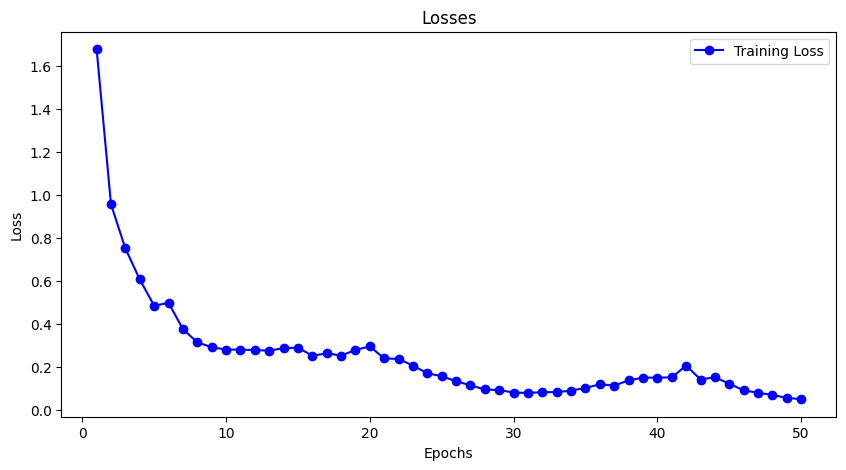

In [ ]:
import matplotlib.pyplot as plt

# Numero di epoche
epochs = range(1, 51)

# Creazione del plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses['train_losses'], label='Training Loss', color='blue', marker='o')

# Aggiunta dei titoli e delle etichette
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
save_path_vtp = '/content/drive/MyDrive/Computer Vision/CV Project/Models/VTPModel.pth'
torch.save(model.state_dict(), save_path_vtp)

In [ ]:
#Load the model
input_size_trajectory = 2
input_size_status = 4
target_lengths = 5
hidden_size = 128
num_layers = 2
cnn_path = "/content/drive/MyDrive/Computer Vision/CV Project/Models/resnet18-f37072fd.pth"
save_path_vtp = '/content/drive/MyDrive/Computer Vision/CV Project/Models/VTPModel.pth'

loaded_model = VTPModel(input_size_trajectory, input_size_status, hidden_size, num_layers, device, target_lengths, cnn_path)
loaded_model.load_state_dict(torch.load(save_path_vtp, map_location=torch.device(device)))
loaded_model.to(device)
print(loaded_model.device)

cpu


## Testing


In [ ]:
#optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
optimizer = optim.Adam(loaded_model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10)
num_epochs = 50

#trainer1 = Trainer(model=model, optimizer=optimizer,scheduler=scheduler, epochs=num_epochs)
trainer1 = Trainer(model=loaded_model, optimizer=optimizer,scheduler=scheduler, epochs=num_epochs)
trainer1.evaluate(test_dataloader)

<ipython-input-14-5c0973aec5b4>:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  target_coordinates = torch.tensor([x_values, y_values], dtype=torch.float32).T


(0.1605619192123413, 0.9866809248924255)

In [ ]:
#trainer1 = Trainer(model, optimizer, num_epochs)
trainer1 = Trainer(loaded_model, optimizer, num_epochs)
predictions = trainer1.predict(test_dataloader)

In [ ]:
predictions

{9: tensor([[0.1816, 0.4693],
         [0.1522, 0.4544],
         [0.1211, 0.4359],
         [0.0907, 0.4155],
         [0.0626, 0.3951]]),
 61: tensor([[0.5185, 0.7466],
         [0.4892, 0.7919],
         [0.4629, 0.8457],
         [0.4377, 0.8964],
         [0.4159, 0.9428]]),
 83: tensor([[0.6484, 0.8454],
         [0.6225, 0.8394],
         [0.6092, 0.8424],
         [0.5930, 0.8432],
         [0.5757, 0.8449]]),
 91: tensor([[0.7958, 0.7566],
         [0.8397, 0.7888],
         [0.8889, 0.8256],
         [0.9319, 0.8567],
         [0.9711, 0.8822]]),
 93: tensor([[0.5337, 0.8707],
         [0.5045, 0.8800],
         [0.4822, 0.8950],
         [0.4566, 0.9062],
         [0.4298, 0.9156]]),
 96: tensor([[0.2223, 0.4970],
         [0.1759, 0.4641],
         [0.1277, 0.4291],
         [0.0841, 0.3966],
         [0.0490, 0.3698]]),
 113: tensor([[0.5649, 0.6180],
         [0.5487, 0.6618],
         [0.5330, 0.7055],
         [0.5170, 0.7460],
         [0.5029, 0.7841]]),
 118: tensor(

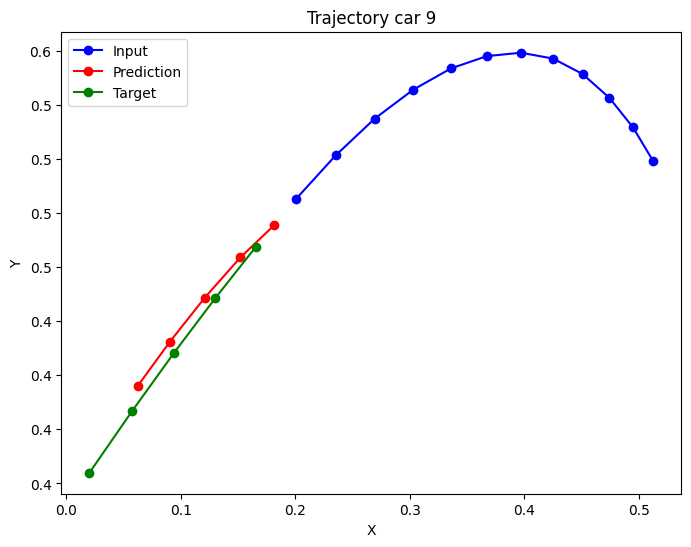

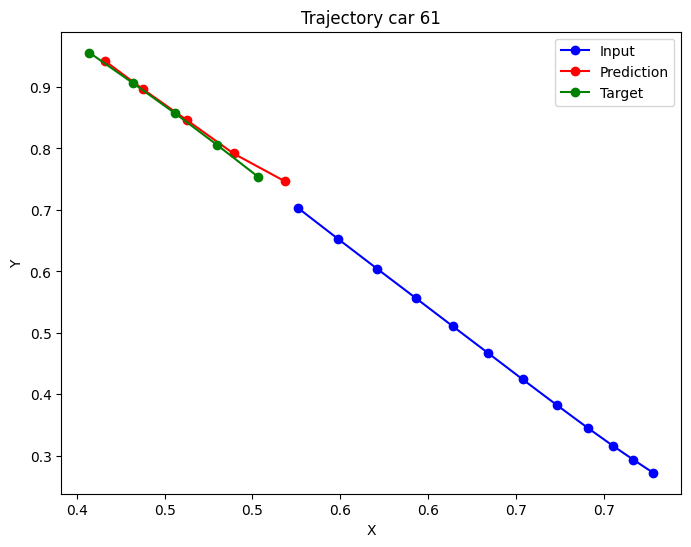

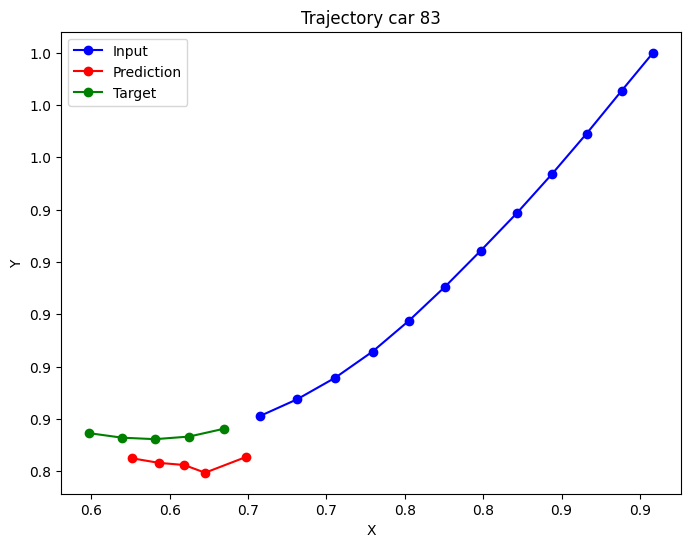

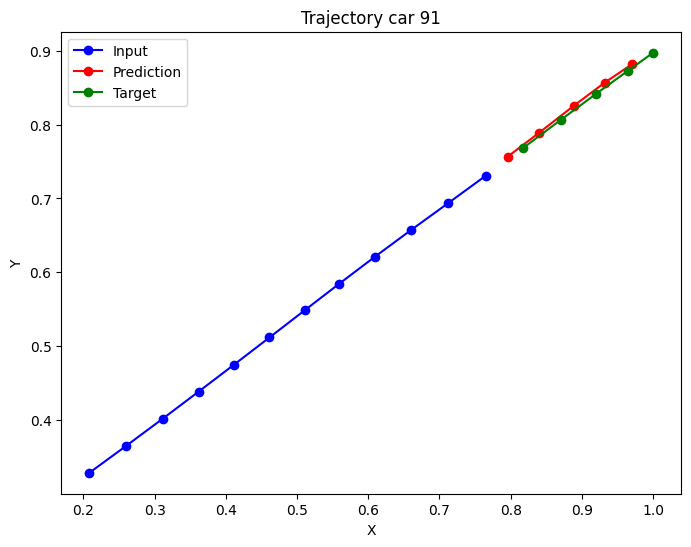

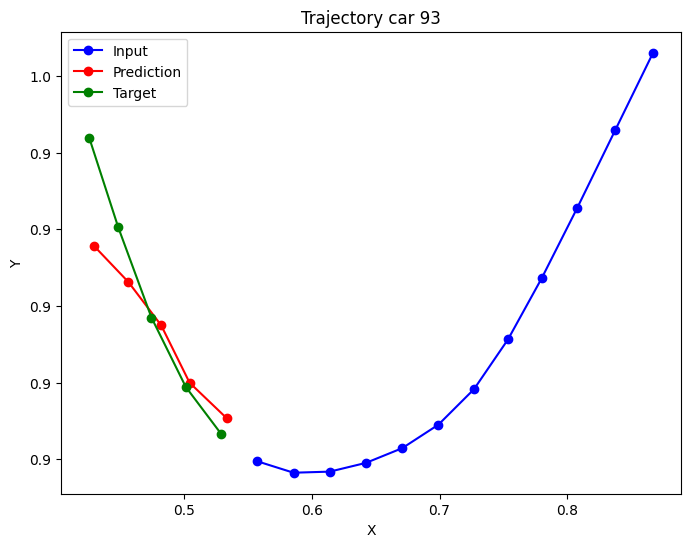

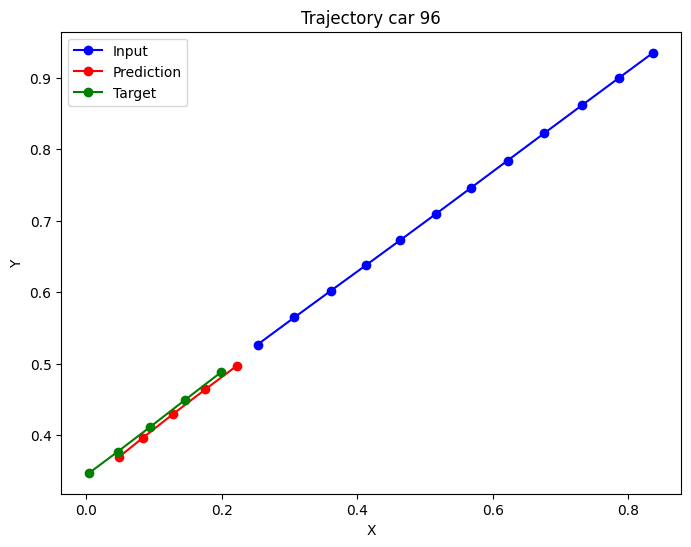

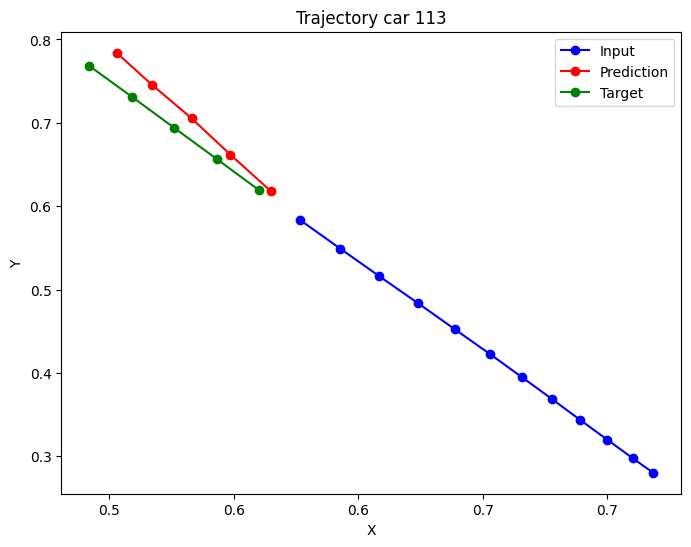

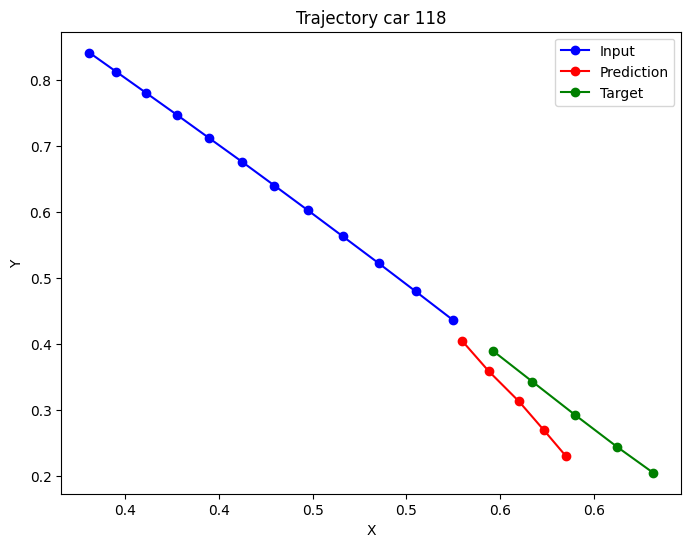

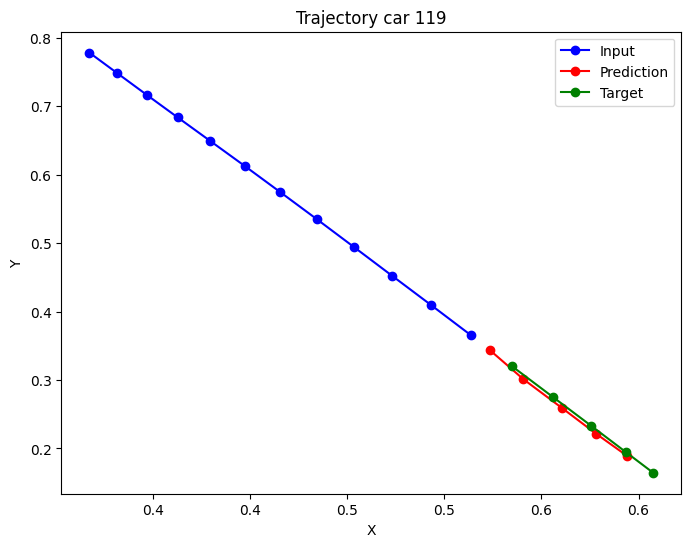

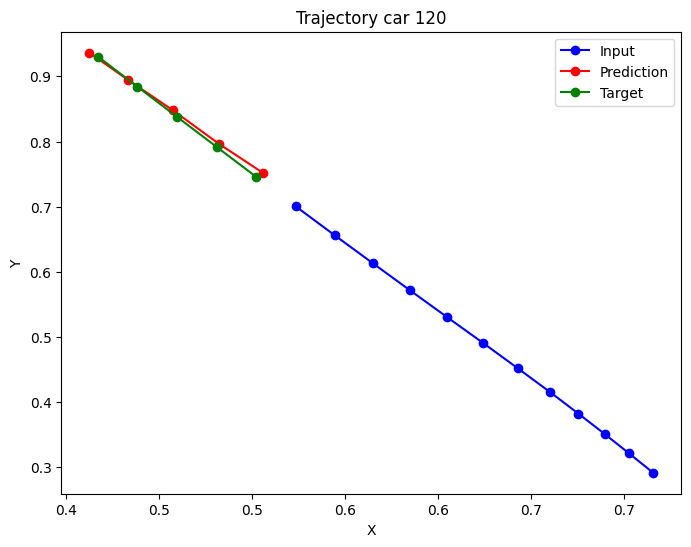

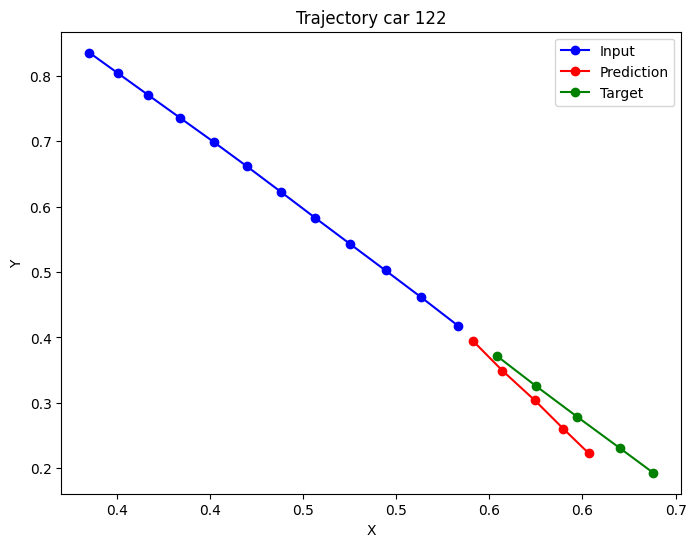

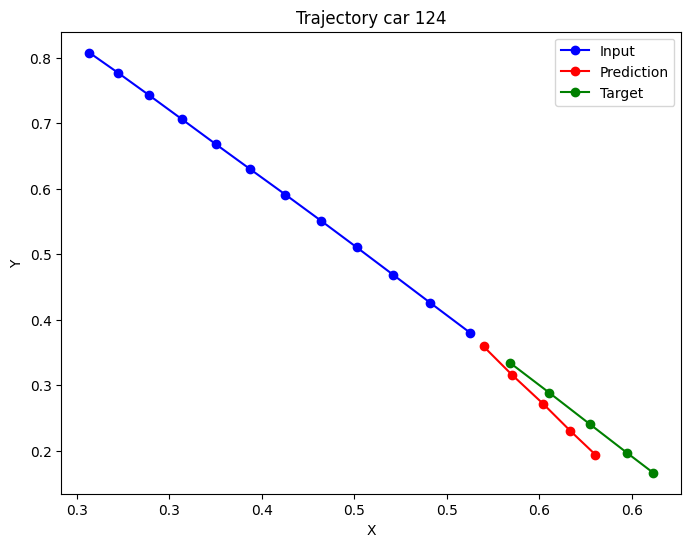

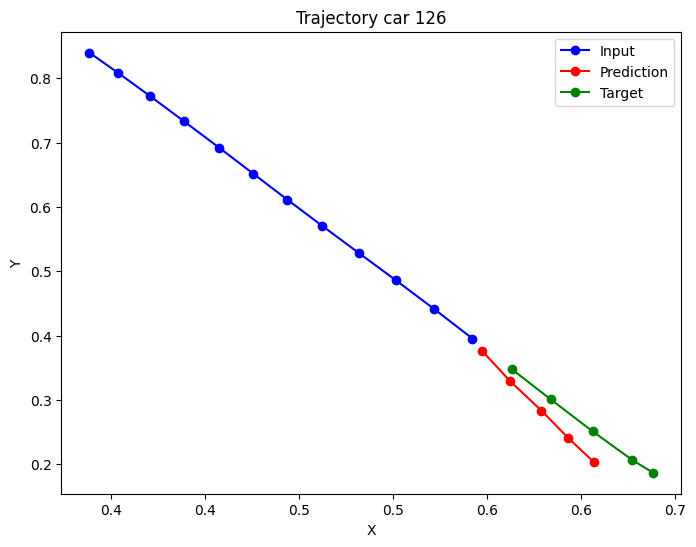

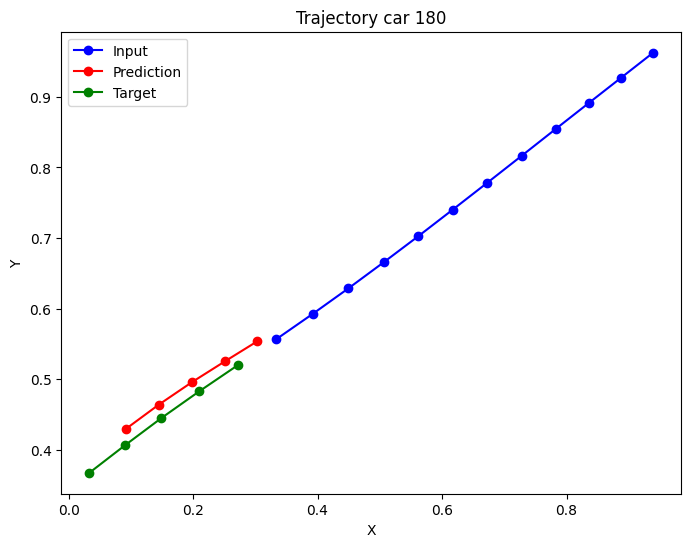

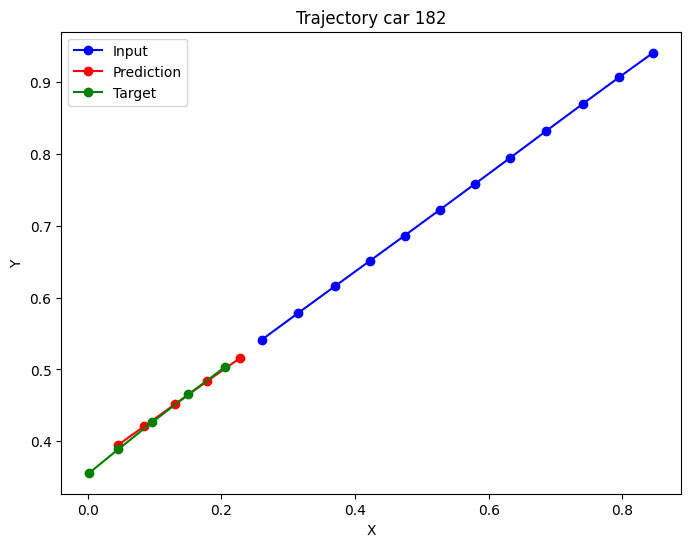

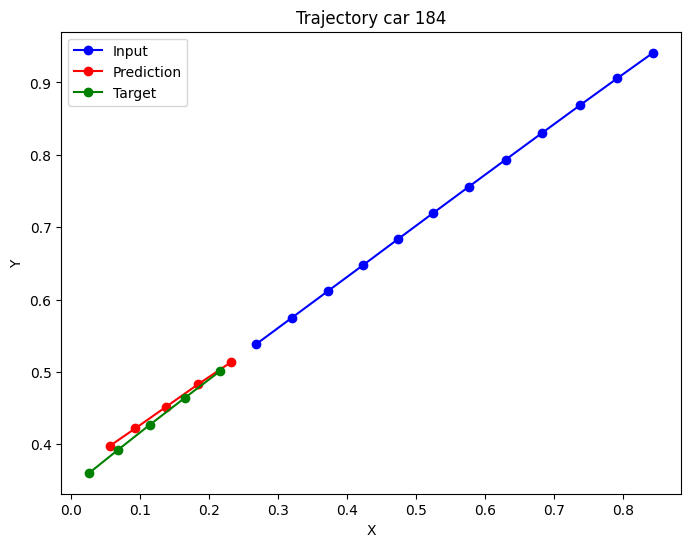

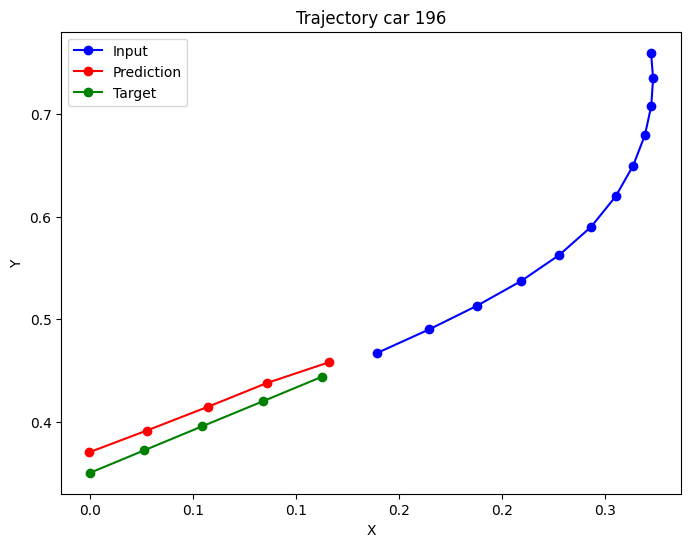

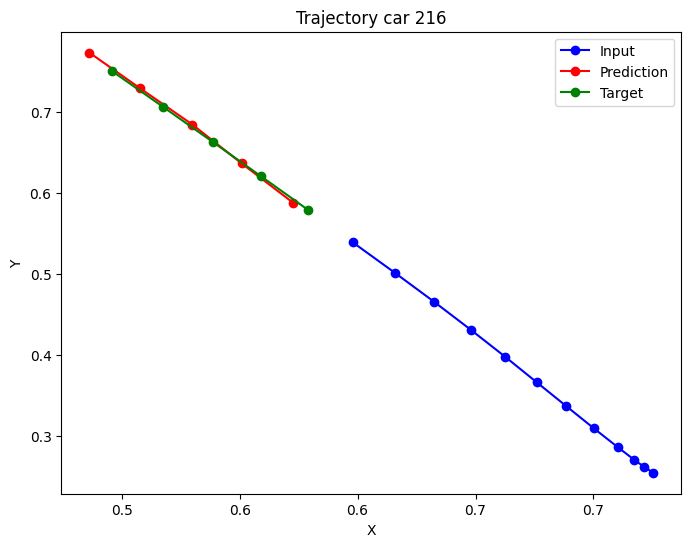

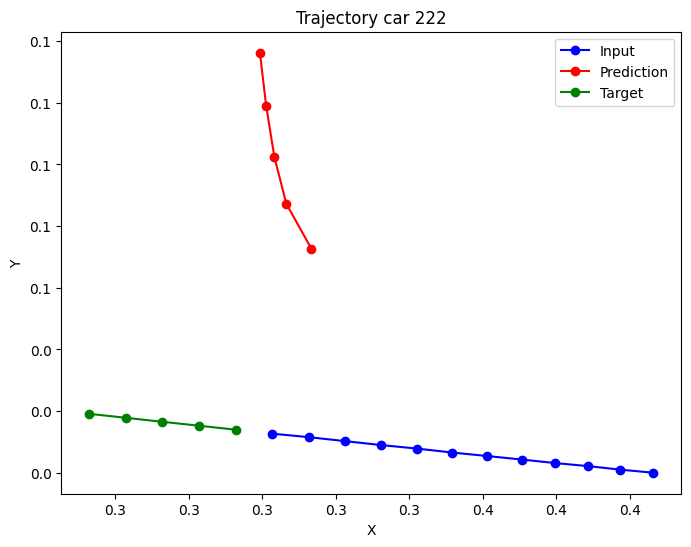

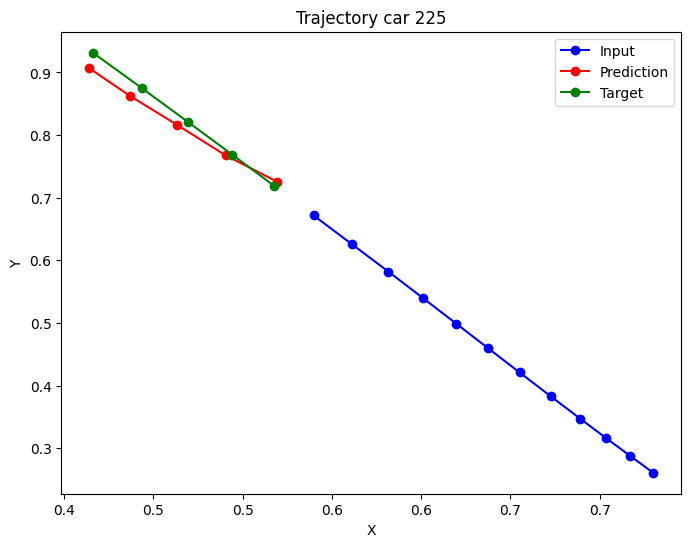

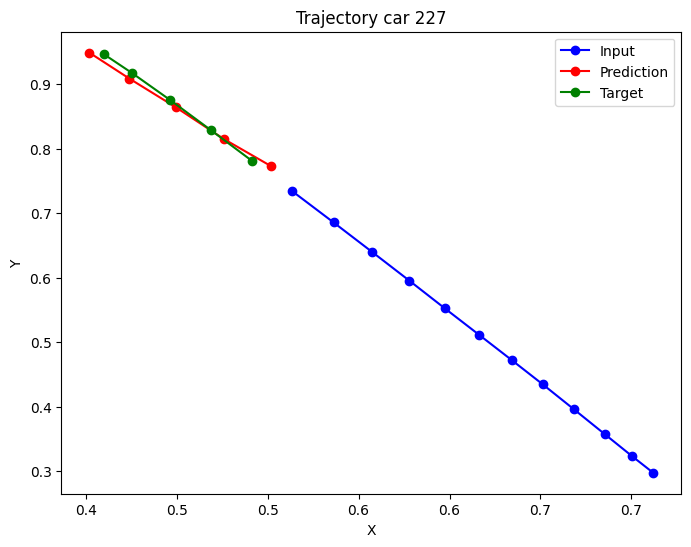

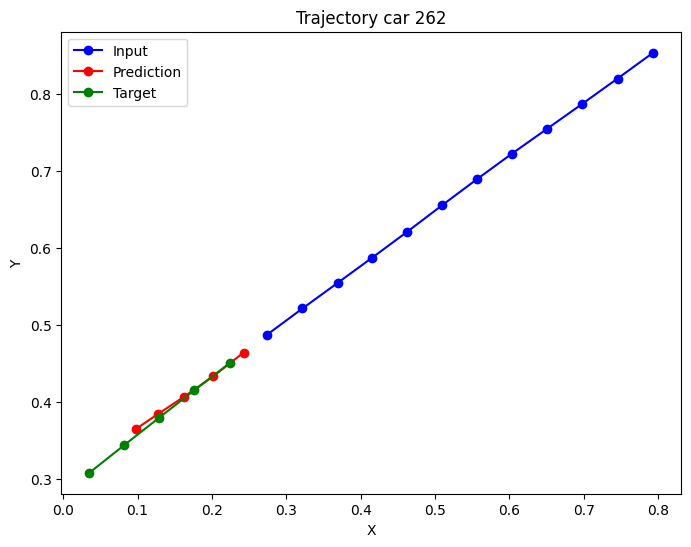

In [ ]:
for i in range(len(test_dataset)):
  image_test, input_test, status_test, target_test, id_test = test_dataset.__getitem__(i)
  plot_trajectories(input_test, target_test, predictions, id_test.item())

In [ ]:
for i in range(len(test_dataset)):
  image_test, input_test, status_test, target_test, id_test = test_dataset.__getitem__(i)
  create_gif_trajectories(input_test, target_test, predictions, id_test.item())